In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [2]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
corrmat = train.corr()
corrmat

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


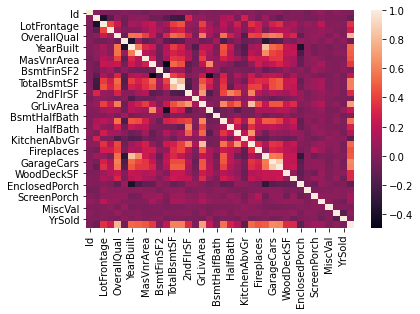

In [4]:
sns.heatmap(corrmat)

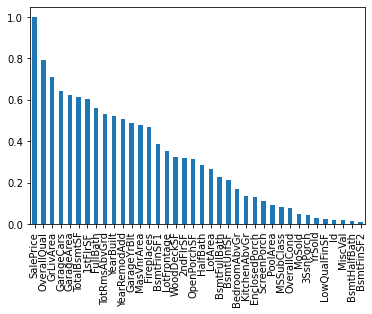

In [18]:
abs(train.corr()['SalePrice']).sort_values(ascending=False).plot.bar()

In [19]:
most_10_important = abs(corrmat["SalePrice"]).sort_values(ascending=False)[1:11].index
most_10_important

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd'],
      dtype='object')

In [6]:
X_train = train[most_10_important]
X_test = test[most_10_important]
X_train.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
0,7,1710,2,548,856,856,2,8,2003,2003
1,6,1262,2,460,1262,1262,2,6,1976,1976
2,7,1786,2,608,920,920,2,6,2001,2002
3,7,1717,3,642,756,961,1,7,1915,1970
4,8,2198,3,836,1145,1145,2,9,2000,2000


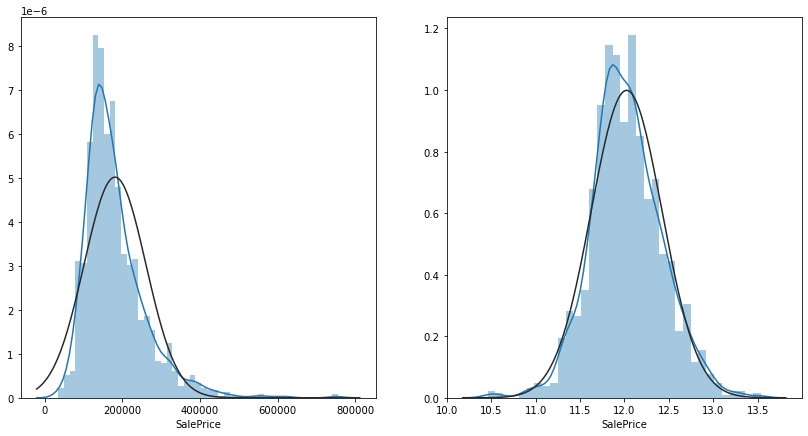

In [55]:
from scipy.stats import norm
plt.figure(figsize=(14,7))
plt.subplot(121)
sns.distplot(train['SalePrice'], fit=norm)
plt.subplot(122)
sns.distplot(np.log(train['SalePrice']),fit=norm)

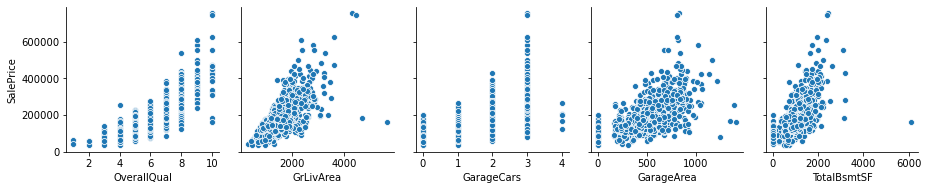

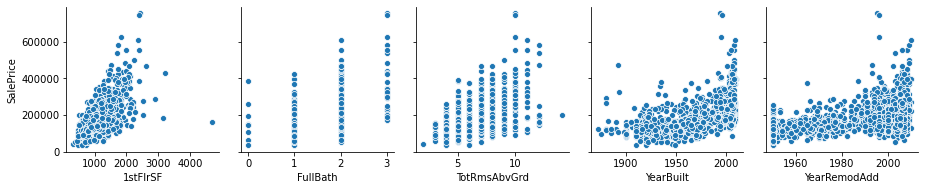

In [56]:
sns.pairplot(x_vars=most_10_important[0:5], y_vars=['SalePrice'], data=train, dropna=True)
sns.pairplot(x_vars=most_10_important[5:], y_vars=['SalePrice'], data=train, dropna=True)
# help(sns.pairplot)

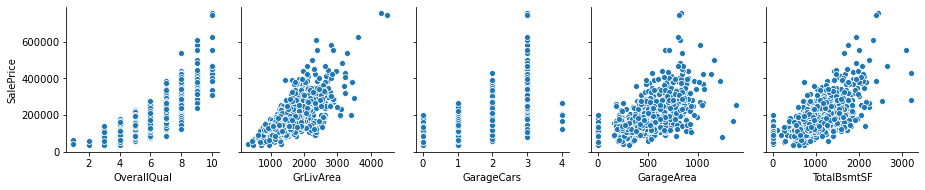

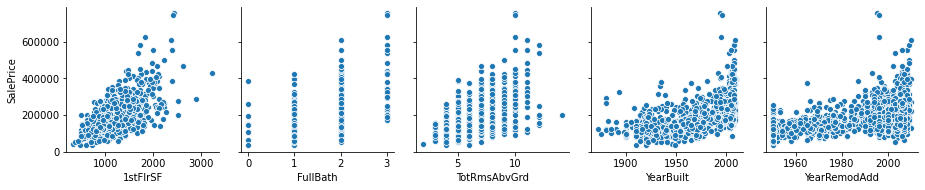

In [59]:
#删除异常值
train = train.drop(train[(train['OverallQual']<5) &
                                        (train['SalePrice']>200000)].index)
 
train = train.drop(train[(train['GrLivArea']>4000) &
                                        (train['SalePrice']<300000)].index)
 
train = train.drop(train[(train['YearBuilt']<1900) &
                                        (train['SalePrice']>400000)].index)
train = train.drop(train[(train['TotalBsmtSF']>6000) &
                                        (train['SalePrice']<200000)].index)
sns.pairplot(x_vars=most_10_important[0:5], y_vars=['SalePrice'], data=train, dropna=True)
sns.pairplot(x_vars=most_10_important[5:], y_vars=['SalePrice'], data=train, dropna=True)
# help(sns.pairplot)

In [8]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   int64  
 1   GrLivArea     1459 non-null   int64  
 2   GarageCars    1458 non-null   float64
 3   GarageArea    1458 non-null   float64
 4   TotalBsmtSF   1458 non-null   float64
 5   1stFlrSF      1459 non-null   int64  
 6   FullBath      1459 non-null   int64  
 7   TotRmsAbvGrd  1459 non-null   int64  
 8   YearBuilt     1459 non-null   int64  
 9   YearRemodAdd  1459 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 114.1 KB


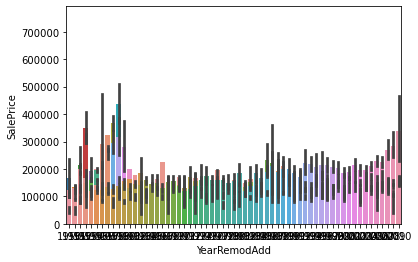

In [16]:
for col in X_train.columns:
    sns.barplot(X_train[col], train['SalePrice'])

In [10]:
X_train['YearBuilt'] = X_train['YearBuilt'].astype(str)
X_train['YearRemodAdd'] = X_train['YearRemodAdd'].astype(str)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   OverallQual   1460 non-null   int64 
 1   GrLivArea     1460 non-null   int64 
 2   GarageCars    1460 non-null   int64 
 3   GarageArea    1460 non-null   int64 
 4   TotalBsmtSF   1460 non-null   int64 
 5   1stFlrSF      1460 non-null   int64 
 6   FullBath      1460 non-null   int64 
 7   TotRmsAbvGrd  1460 non-null   int64 
 8   YearBuilt     1460 non-null   object
 9   YearRemodAdd  1460 non-null   object
dtypes: int64(8), object(2)
memory usage: 114.2+ KB


C:\Users\mingm\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\mingm\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
X_test['YearBuilt'] = X_test['YearBuilt'].astype(str)
X_test['YearRemodAdd'] = X_test['YearRemodAdd'].astype(str)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1459 non-null   int64  
 1   GrLivArea     1459 non-null   int64  
 2   GarageCars    1458 non-null   float64
 3   GarageArea    1458 non-null   float64
 4   TotalBsmtSF   1458 non-null   float64
 5   1stFlrSF      1459 non-null   int64  
 6   FullBath      1459 non-null   int64  
 7   TotRmsAbvGrd  1459 non-null   int64  
 8   YearBuilt     1459 non-null   object 
 9   YearRemodAdd  1459 non-null   object 
dtypes: float64(3), int64(5), object(2)
memory usage: 114.1+ KB


C:\Users\mingm\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\mingm\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
object_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
good_label_cols = [col for col in object_cols if
                  set(X_train[col])==set(X_test[col])]
print(good_label_cols)
bad_label_cols = list(set(object_cols)-set(good_label_cols))
bad_label_cols
# data = train.drop(bad_label_cols, axis=1)
# test_dropna = test.drop(bad_label_cols, axis=1)

# object_cols = [col for col in data.columns if data[col].dtype == 'object']
# data[object_cols] = data[object_cols].fillna('NULL')
# test_dropna[object_cols] = test_dropna[object_cols].fillna('NULL')
# data.head()
# print(test_dropna)

['YearRemodAdd']


['YearBuilt']

In [36]:
y_train = train['SalePrice']

In [37]:
def num_cat_splitor(X_train):
    s = (X_train.dtypes == 'object')
    object_cols = list(s[s].index)
    # object_cols # ['package', 'division', 'salary']
    num_cols = list(set(X_train.columns) - set(object_cols))
    # num_cols
    # ['Work_accident', 'time_spend_company', 'promotion_last_5years', 'id',
    #  'average_monthly_hours',  'last_evaluation',  'number_project']
    return num_cols, object_cols
num_cols, object_cols = num_cat_splitor(X_train)
print(num_cols)
print(object_cols)
# X[object_cols].values

['GrLivArea', 'TotalBsmtSF', 'TotRmsAbvGrd', 'FullBath', 'GarageCars', 'OverallQual', '1stFlrSF', 'GarageArea']
['YearBuilt', 'YearRemodAdd']


In [49]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_cols)),
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(object_cols)),
#         ('imputer', SimpleImputer(strategy="most_frequent")), # 不能对文字特征插值
        ('cat_encoder', OneHotEncoder(sparse=False,handle_unknown='ignore')),
    ])
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])
X_prepared = full_pipeline.fit_transform(X_train)

In [50]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_scores = cross_val_score(forest_reg,X_prepared,y_train,
                               scoring='neg_mean_squared_error',cv=3)
forest_rmse_scores = np.sqrt(-forest_scores)
print(forest_rmse_scores)
print(forest_rmse_scores.mean())
print(forest_rmse_scores.std())

[29687.05436858 34998.53250359 35065.50540594]
33250.36409270418
2519.788811909198


In [51]:
param_grid = [
    {'n_estimators' : [100,200,300],'max_features':[15,25,35,45,55,65,70]},
#     {'bootstrap':[False], 'n_estimators' : [3,10],'max_features':[2,3,4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error')
grid_search.fit(X_prepared,y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [15, 25, 35, 45, 55, 65, 70],
                          'n_estimators': [100, 200, 300]}],
             scoring='neg_mean_squared_error')

In [52]:
grid_search.best_params_

{'max_features': 55, 'n_estimators': 300}

In [53]:
cv_result = grid_search.cv_results_
for mean_score, params in zip(cv_result['mean_test_score'], cv_result['params']):
    print(np.sqrt(-mean_score), params)

33981.58863228619 {'max_features': 15, 'n_estimators': 100}
33551.719489978794 {'max_features': 15, 'n_estimators': 200}
34035.21394749354 {'max_features': 15, 'n_estimators': 300}
34025.92662620481 {'max_features': 25, 'n_estimators': 100}
33425.786017397695 {'max_features': 25, 'n_estimators': 200}
33525.75748951741 {'max_features': 25, 'n_estimators': 300}
33498.24001099252 {'max_features': 35, 'n_estimators': 100}
33099.414948853584 {'max_features': 35, 'n_estimators': 200}
33301.58982475788 {'max_features': 35, 'n_estimators': 300}
33410.770944237134 {'max_features': 45, 'n_estimators': 100}
33187.155868711496 {'max_features': 45, 'n_estimators': 200}
33296.871242253736 {'max_features': 45, 'n_estimators': 300}
33326.22042667233 {'max_features': 55, 'n_estimators': 100}
33277.106693153306 {'max_features': 55, 'n_estimators': 200}
33012.173859283575 {'max_features': 55, 'n_estimators': 300}
33023.48193907254 {'max_features': 65, 'n_estimators': 100}
33189.6775477124 {'max_features'

In [54]:
feature_importances = grid_search.best_estimator_.feature_importances_


In [55]:
k = 3
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]


In [56]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
#     ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('forst_reg', RandomForestRegressor(random_state=0))
])
param_grid = [{
    'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
#     'feature_selection__k': list(range(20, len(feature_importances) + 1)),
    'forst_reg__n_estimators' : [50,100, 150, 200,250,300,330,350],
#     'forst_reg__max_features':[45,50, 55, 65]
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=7,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)


In [57]:
grid_search_prep.fit(X_train,y_train)
grid_search_prep.best_params_
final_model = grid_search_prep.best_estimator_

Fitting 7 folds for each of 24 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:  1.9min finished


In [58]:
grid_search_prep.cv_results_

{'mean_fit_time': array([1.05062335, 1.05503971, 1.07199543, 2.1932885 , 2.21907435,
        2.18573625, 3.18335945, 3.26457191, 3.16469431, 4.14792865,
        4.13382346, 4.13966319, 5.17247772, 5.25468806, 5.32948749,
        6.20500864, 6.58884202, 7.26147383, 7.89791911, 8.58650909,
        7.66254684, 9.06295156, 9.60179898, 8.14882105]),
 'std_fit_time': array([0.01454052, 0.01757181, 0.02439074, 0.03424848, 0.03536904,
        0.02745817, 0.04506034, 0.04950279, 0.07523414, 0.04972278,
        0.04120118, 0.03365163, 0.03971291, 0.08039689, 0.07679313,
        0.04174855, 0.23074378, 0.10249115, 0.17488294, 0.14130563,
        0.18851622, 0.45519641, 0.15956286, 0.7705374 ]),
 'mean_score_time': array([0.01595834, 0.01681328, 0.0183817 , 0.02493456, 0.02678626,
        0.023081  , 0.03006274, 0.02821013, 0.03006332, 0.03618908,
        0.03690076, 0.03547692, 0.04402563, 0.04943967, 0.0487271 ,
        0.05399936, 0.06211959, 0.06197752, 0.09403576, 0.06126414,
        0.062547

In [59]:
y_pred_test = final_model.predict(X_test)
result = pd.DataFrame()
result['Id'] = test['Id']
result['SalePrice'] = y_pred_test
result.to_csv('housing_price_10_features.csv',index=False)
